# Prosjekt 2 #

**Introduksjon**

I prosjekt 2 i TMA4320 introduseres delen av maskinlæring med navn dyplæring. Idéen med prosjektet er å programmere en datamaskin til å binærklassifisere. Det brukes en modell som anvender suksessivt en serie av transformasjoner på hvert bilde. Hver transformasjon er knyttet til et sett parametre. Etter siste transformasjon projiseres resultatet til en skalar verdi mellom 0 og 1. Bildet vil tolkes som den verdien projiseringen ligger nærmest.

Videre regnes ut akkumulert avvik mellom fasit og modellens konklusjon ved hjelp av en kostfunksjon. Avviket sier noe om hvor langt unna modellen er i å klassifisere perfekt resultat. Herfra er strategien å søke etter parameterverdier knyttet til hver transformasjon som gjør at avviket blir minst mulig. Dette er treningsfasen. Når parameterverdiene er satt, testes modellen på nye bilder for deretter å se om vi får ønsket konklusjon i validerings- eller testfasen.

Rapporten viser til en introduksjon etterfulgt av celler med kode, en presentasjon av resultat for spiral-eksempelet, og tilsvarende for MNIST. Det er også lagt til kommentarer underveis for å tydeliggjøre struktur og fremgangsmåte. 

**Importerer nødvendige pakker**

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import norm
from spirals import get_data_spiral_2d
from plotting import plot_progression 
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string)) #For å kunne skrive ut i fet tekst

ModuleNotFoundError: No module named 'spirals'

**Definerer funksjoner**

In [254]:
def addMatVec(W, Y, b, k):
    return ((W[k,:,:]@Y[k,:,:]) + b[k,:])

def yNext(Y, W, b, k): 
       return Y[k,:,:] + h*np.tanh(addMatVec(W,Y,b,k))

def Z(Y):
    return eta((Y[(K-1),:,:].T)@w + my) #skal her bruke den siste Y_{k}, K !

'''ForewardFunction som brukes til plotting av resultater på Spiralen'''
def Z0(grid): 
    I,d=np.shape(grid)
    Y=np.zeros((K+1,I,d))
    Y[0]=grid
    for k in range(1,K+1):
        Y[k,:,:] =Y[k-1,:,:] + h*np.tanh(addMatVec(W,Y,b,k-1))
    return eta((Y[-1].T)@w + my)

'''lastFunction som brukes til plotting av resultater på Spiralen'''
def Z_last(Y): 
    return eta((Y.T)@w + my)
    
def eta(x): 
    return (np.exp(x))/(np.exp(x) + 1)

def deta(x):
    return np.exp(x)/(np.exp(x)+1)**2

def dsig(x):
    return 4/(np.exp(x)+np.exp(-x))**2

def pPrev(P, k):
    return P[k,:,:] + h*(W[(k-1),:,:].T)@np.multiply(dsig(addMatVec(W,Y,b,k-1)),P[k,:,:])

**Finner Gradienten**

In [255]:
#U = np.array([W, b, w, my])
def find_gradient(U):
    dW = h*(P*dsig(U[0]@Y+U[1]))@(Y.transpose((0, 2, 1))) 
    db = h*(P*dsig(U[0]@Y+U[1]))@np.ones((I,1))
    dmy = np.transpose(deta(np.transpose(Y[(K-1),:,:])@U[2] + U[3]))@(Z(Y)-c)             
    dw = Y[K-1,:,:]@((Z(Y)-c)*deta((Y[K-1,:,:].T)@U[2] + U[3]))      
    
    return np.array([dW, db, dw, dmy])

**Plain Vanilla**

In [256]:
def vanilla(W,b,w,my):
    U = np.array([W, b, w, my])
    gU = find_gradient(U)
    U = U - tau*gU
    return U

**Adam-metoden**

In [257]:
def adam(W,b,w,my,j, m, v):
    U = np.array([W, b, w, my])
    g = find_gradient(U) #Tar U, returnerer oppdatert U

    beta_1=0.9
    beta_2=0.999
    alpha = 0.01            #steglengde  
    epsilon = 1e-8        
    g = find_gradient(U)
    m = beta_1 * m + (1 - beta_1) * g     
    v = beta_2 * v + (1 - beta_2) * (g*g)
    m_hat = m / (1 - beta_1**j)
    v_hat = v / (1 - beta_2**j)
    for i in range(len(v_hat)): #tar sqrt(v_hat)
        v_hat[i] = np.sqrt(v_hat[i])
    U = U - alpha * m_hat / (v_hat + epsilon)
    return U, m, v #returnerer m og v for å oppdatere disse

# SPIRAL #

In [41]:
def matrics_n_vec(config_file):
    """
    Make the matrix and vetors
    input:  
        p: dictionary from config-file
    output: 
        matrix and vectors
    """
    
    with open(config_file, 'r') as config:
        conf = json.load(config)

    K, tau, h, d, num, my = conf['parameters'].values()
  
   
    Y = np.ones((K,d,I)) 
    W = np.random.randn(K, d, d) 
    b = np.random.randn(K, d, 1) 
    P = np.ones((K,d,I)) 
    c = np.ones((I,1))
    w = np.ones((d,1)).fill(3) 
    
    mat_n_vec = {"Y" : Y, 
                "W" : W,
                "b" : b, 
                "P" : P, 
                "c" : c, 
                "w" : w, 
                "my" : my, 
                "tau" : tau}
    return mat_n_vec

In [43]:
mhm = matrics_n_vec('data/config_spiral.json')
mhm


{'Y': array([[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],
 
        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],
 
        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],
 
        ...,
 
        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],
 
        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],
 
        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]]]),
 'W': array([[[-0.86604027, -0.04928871],
         [-0.98833828,  0.8975703 ]],
 
        [[-1.66884789, -1.21188934],
         [-0.63138658, -0.09201664]],
 
        [[-0.23237723,  0.07850246],
         [ 1.6273415 , -0.34135692]],
 
        [[ 1.07770775,  0.6817086 ],
         [-0.71189334, -0.37086022]],
 
        [[ 0.40314075, -1.45973643],
         [ 0.29431027,  0.31757446]],
 
        [[ 1.55678314, -1.27309173],
         [-0.88336725, -0.06884311]],
 
        [[-1.05

**Henter inn data**

In [259]:
verdier = get_data_spiral_2d(I)
c = verdier[1]
Y[0,:,:] = verdier[0]    #første k-verdi til Y til koordinater

**Trening av parametere**

In [260]:
'''Oppretter m og v i rette dimensjoner'''
p = np.zeros((K,d,d))
q = np.zeros((K,d, 1))
s = np.zeros((d, 1))
x = 0
m = np.array([p,q,s,x]) 
v = m.copy()

'''Oppdaterer konstanter som brukes til å plotte senere'''
WL= np.zeros(4000)
wL= np.zeros(4000)
bL= np.zeros(4000)
myL= np.zeros(4000)
rett = np.zeros(4000)
mL = np.zeros(4000)
JL = np.zeros(4000)

def train():
    """
    Add a config file in the input so thath 
    you dont have to take in so many variables
    Store the values in a json-file so that 
    you don´t have to return so many variables
    """
    put = 0
    iterr = 0
    while iterr < 10000:
        for i in range(K-1):
            Y[i+1,:,:] = yNext(Y, W, b, i)
        P[K-1,:,:] = w@(((Z(Y)-c)*deta((Y[(K-1),:,:].T)@w+my)).T) #skal her bruke den siste Y_{k}, K !
        for i in range(K-1):
            P[K-2-i,:,:] = pPrev(P,(K-1-i))
        U,m,v = adam(W,b,w,my,iterr + 1, m, v) #starter iterasjonen på 1 for å unngå å dele på 0
        #U = vanilla(W,b,w,my) 
        W = U[0]
        b = U[1]
        w = U[2]
        my = U[3]
        if iterr%10 == 0:
            WL[put] = W[-1,0,0]
            wL[put] = w[0,0]
            bL[put] = b[0,0]
            myL[put] = my
            JL[put] =  0.5*norm(Z(Y)-c)**2
            put += 1
        iterr+=1
    every_tenth_run = np.array([WL, bL, wL, myL, JL])
    return every_tenth_run, J, Z, c

**Plotter W, b, w, μ og J mot antall iterasjoner**

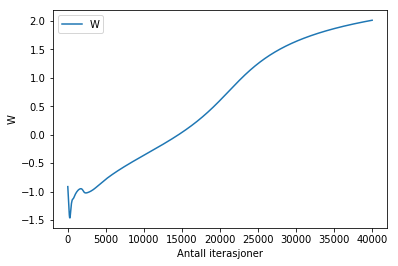

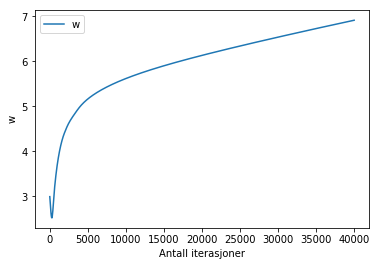

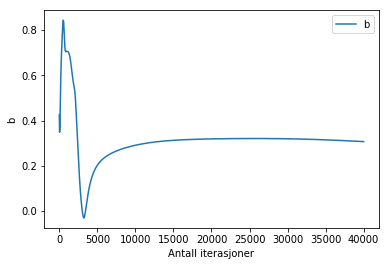

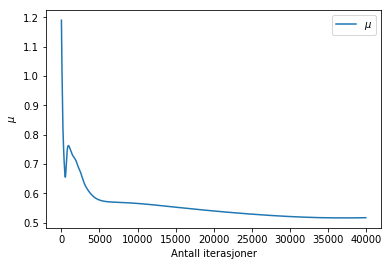

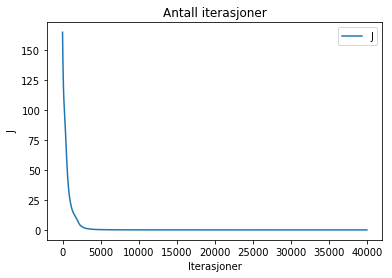

In [261]:
plt.plot(np.linspace(0,40000,put), WL[:put], label = 'W')
plt.xlabel('Antall iterasjoner')
plt.ylabel('W')
plt.legend()
plt.show()

plt.plot(np.linspace(0,40000,put), wL[:put], label = 'w')
plt.xlabel('Antall iterasjoner')
plt.ylabel('w')
plt.legend()
plt.show()

plt.plot(np.linspace(0,40000,put), bL[:put], label = 'b')
plt.xlabel('Antall iterasjoner')
plt.ylabel('b')
plt.legend()
plt.show()

plt.plot(np.linspace(0,40000,put), myL[:put], label = '$μ$')
plt.xlabel('Antall iterasjoner')
plt.ylabel('$μ$')
plt.legend()
plt.show()

plt.plot(np.linspace(0,40000,put),JL[:put],label = "J")
plt.title('Antall iterasjoner')
plt.xlabel('Iterasjoner')
plt.ylabel('J')
plt.legend()
plt.show()

Ser at b og $μ$ konvergerer etter ca. 10 000 iterasjoner. $W_{k}$ og w ser ikke ut til å konvergere innenfor antall iterasjoner som vi har valgt, men dette er litt tilfeldig. Ved tidligere kjøringer var det w og $μ$ som ikke konvergerte. Dette kan ha noe med de tilfeldige startverdien til W, b og $μ$. Til tross for manglende konvergens av $W_{k}$ og w viser resultatene lenger nede at vi får mellom 99.0 og 100% rett for hver kjøring vi har gjort. 

Testet videre modellen for ulike verdier steglengde $h$, antall lag $K$ samt ulike verdier for $\alpha$ i Adam-metoden. Her er $\alpha$ tilsvarende det som betegnes som læringsparameteren $\tau$ i Plain Vanilla metoden. 

Nedenfor presenteres tallverdiene for $J$ når ulike parametere varieres. Både $\alpha$ og $h$ varieres innenfor intervallet $[0.01, 0.1]$. Antall lag, $K$, varieres innenfor intervallet $[5,20]$. 
($J$ vises til høyre og parameteren som varieres til venstre)

$J$, $\alpha$ med $h=0.1$ og $K=20$:

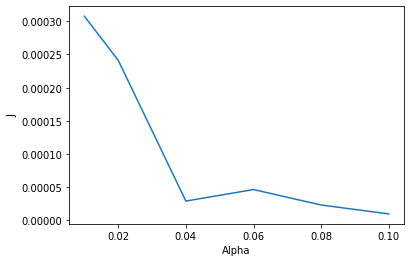

$J$, varierende $h$ med $\alpha = 0.1$ og $K=20$:

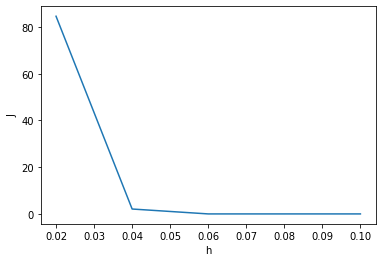

$J$, varierende $K$ med $\alpha = 0.1$ og $h = 0.1$:

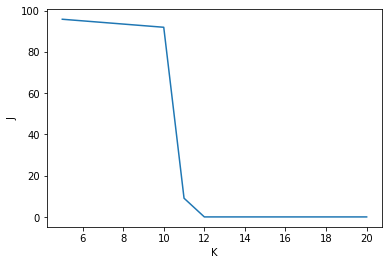

Resultatene viser for større verdier av både $\alpha$ og $h$ blir avviket minst mulig, altså kostfunksjonen $J$ blir minst mulig. Ser at både for $\alpha, h \in [0.04, 0.1]$ gir tilnærmet konvergens for $J$. 

Videre ser vi at for flere lag, altså større $K$, vil også $J$ bli mindre. Mellom $K=10$ og $K=12$ har vi et sprang. Ved kjøring for $K=11$, tar $J$ verdier ca. mellom $J=92$ og $J=10^{-4}$ som varierer for hver kjøring. 

Konkluderer med at i denne oppgaven vil de optimale verdier for de ulike testede parameterne være $\alpha = 0.1$, $h=0.1$ og $K=(13,20]$ innenfor intervallet som er satt. 

**Plotter resultat for treningssettet**

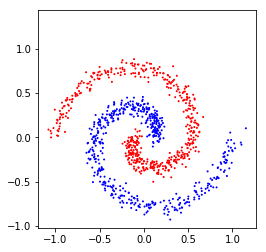

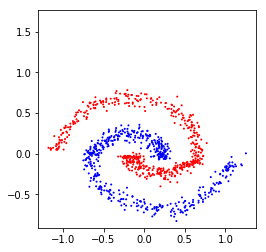

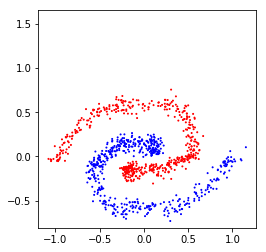

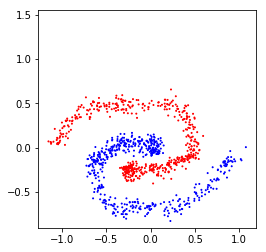

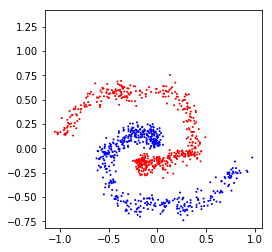

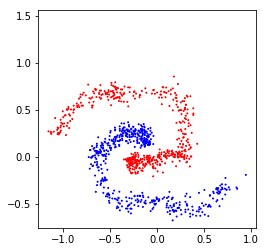

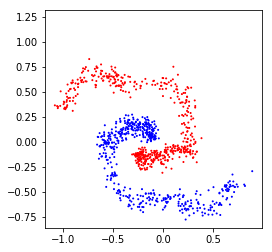

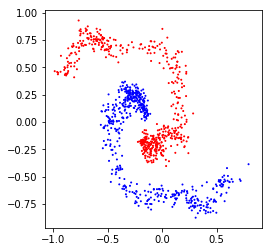

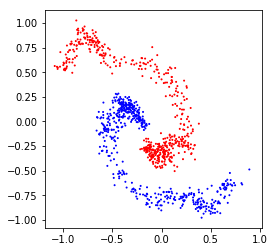

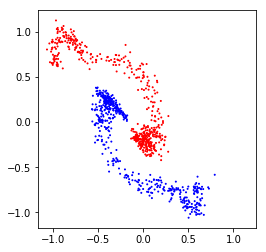

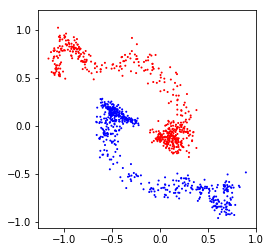

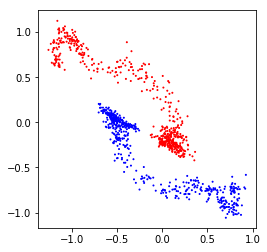

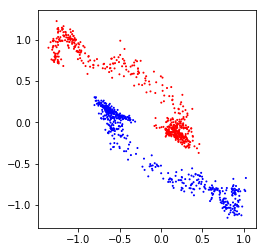

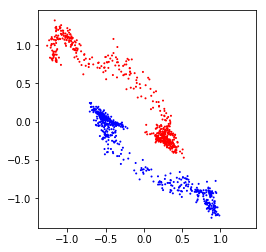

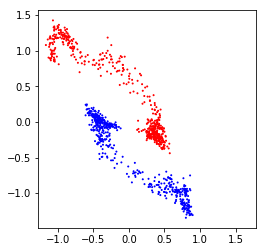

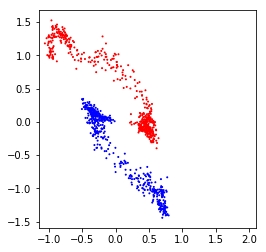

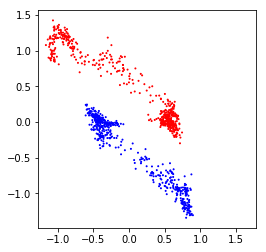

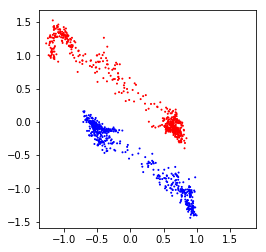

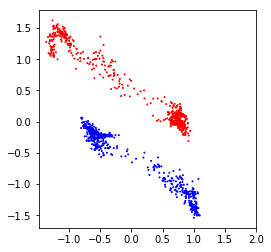

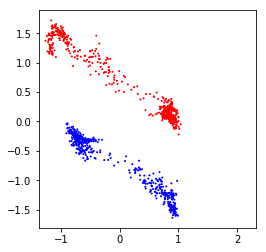

In [262]:
plot_progression(Y,c[:,0])

Ser at punktene deler seg fullstendig. 

In [263]:
J = 0.5*norm(Z(Y)-c)**2
print('Verdien av J ble',J)
diff = Z(Y)-c
pros = 0
for el in diff: 
    if abs(el) >= 0.5:
        pros += 1
prosentandel = pros/I
rett = 1-prosentandel
printmd("**Prosentandel som ble rett:**"+ " " +str(rett*100)+ '%')

Verdien av J ble 0.000412641209999098


**Prosentandel som ble rett:** 100.0%

# TEST-PUNKTER #

**Importerer nytt dataset og tester $W_{k}$ og $b_{k}$ som er regnet ut ved treningssettet**

In [264]:
verdier=get_data_spiral_2d(I)
c = verdier[1]
Y[0,:,:] = verdier[0]    #første k-verdi til Y til koordinater
for i in range(K-1):
    Y[i+1,:,:] = yNext(Y, W, b, i)
J = 0.5*(norm(Z(Y)-c))**2

In [265]:
print("J:",J)
diff = Z(Y)-c
pros = 0
for el in diff: 
    if abs(el) >= 0.5:
        pros += 1
prosentandel = pros/I
rett = 1-prosentandel
printmd("**Prosentandel som ble rett:**"+ " " +str(rett*100)+ '%')

J: 0.9870776123456181


**Prosentandel som ble rett:** 99.8%

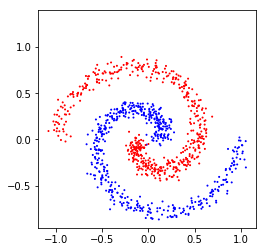

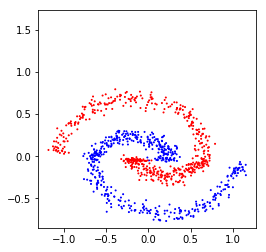

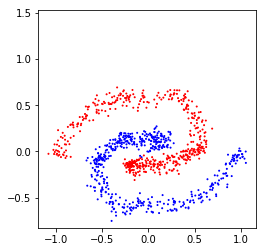

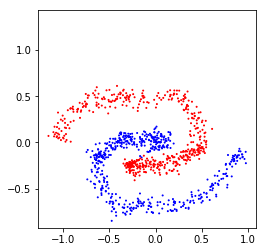

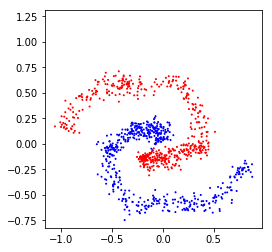

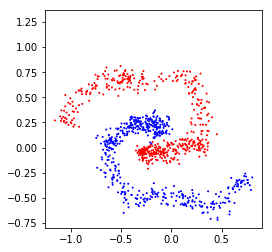

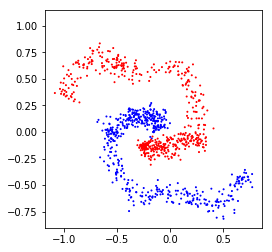

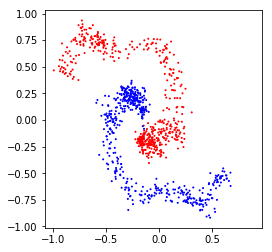

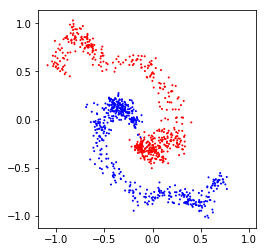

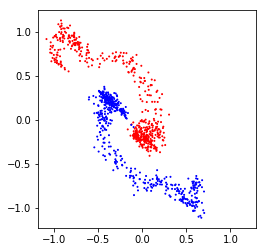

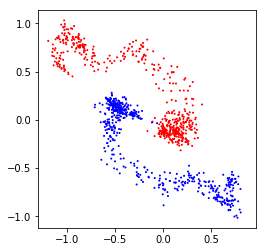

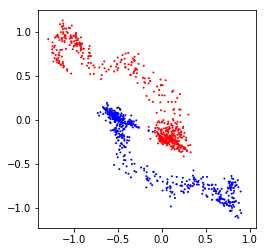

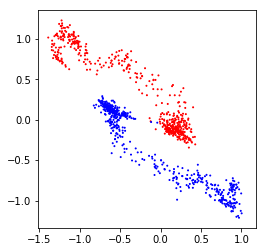

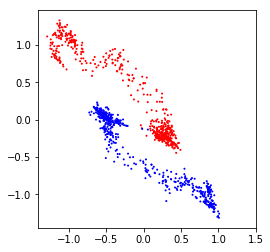

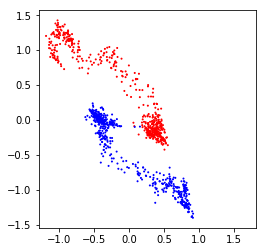

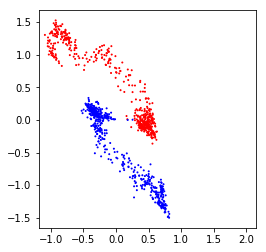

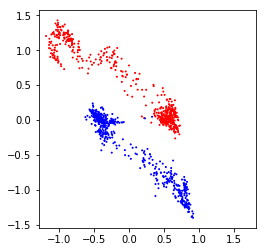

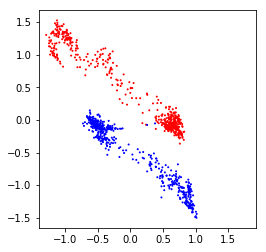

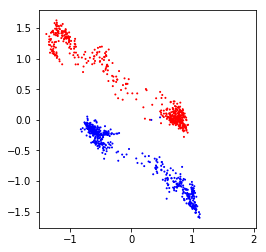

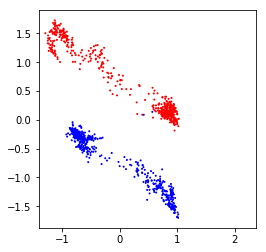

In [266]:
plot_progression(Y,c[:,0])

Ser at det er to punkter som gikk feil.

**Visualisering - Spiral**

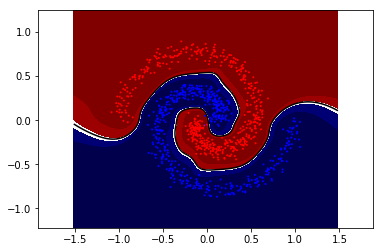

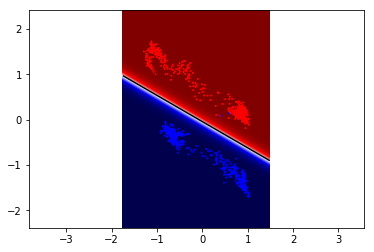

In [267]:
from plotting import plot_model
from plotting import plot_separation


plot_model(Z0, Y[0,:,:],c[:,0],I)
plt.show()
plot_separation(Z_last, Y[-1,:,:], c[:,0], I)

Disse figurene viser hvordan planet ble transformert ved $W_{k}$ og $b_{k}$.

# MNIST #

In [1]:
from loader import get_dataset
from visualisering import printOnePicture  
import numpy as np
#laget en funksjon som printer ut MNIST som bilder for å kunne se hvilke type tall algoritmen vår ikke klarer å skille

**Nullstiller konstanter:**

In [2]:
K = 20 #Antall lag
h = 0.1 #Skrittlengde
d = 784 #Antall piksler i bildet
I = 1000 #Antall bilder
Y = np.ones((K,d,I)) # KxdxI - matrise 
W = np.random.randn(K, d, d) # Kxdxd - matrise. Putter alle matrisene i en vektor for å minimere konstanter
b = np.random.randn(K, d, 1) # en Kxdx1 vektor. (x1 for å få en stående vektor)
P = np.ones((K+1,d,I)) #(K+1) for å kunne følge formlene fra oppgaveteksten, ellers samme dimensjon som Y 
w = np.ones((d,1)) # 1, for stående vektor 
my = np.random.randn() #random tall

**Importerer bilder**

In [3]:
Y0,c0=get_dataset(dataset="training", digit1=2, digit2=7, path=".")
c0 = c0[:I] #henter ut antall bilder

Y0 = Y0/900  #alle blir da et tall mellom 0 og 0.3
Y0 = Y0[:,:I] #henter ut antall bilder
Y[0] = Y0

**Kommentar:**
Deler på 900 for å ikke få for store tall i funksjonene som skal brukes. Prøvde oss frem til vi fant et tall som ga oss gode resultater. Vi antar at dette kan gjøres fordi det gir oss gode resultater og tallene som Y0 består av bare er graderinger av fargeintensiteten, så det skal ikke ha noe å si om det er 255 eller 0.3. 

**Funksjoner for å kunne regne ut $\frac{\partial J}{\partial W_{k}}$ og $\frac{\partial J}{\partial b_{k}}$**

In [271]:
def dW(P,W,b,Y):
    return h*(P*dsig(W@Y+b))@(Y.transpose((0, 2, 1))) 

def db(P,W,b,Y):
    return h*(P*dsig(W@Y+b))@np.ones((I,1))

**Adam decent**

In [272]:
def adam(X, dX, j, m, v):
    beta_1=0.9
    beta_2=0.999
    alpha = 0.01            #steglengde
    epsilon = 1e-8
    
    g = dX

    m = beta_1 * m + (1 - beta_1) * g     
    v = beta_2 * v + (1 - beta_2) * (g*g)
    m_hat = m / (1 - beta_1**j)
    v_hat = v / (1 - beta_2**j)
    for iu in range(len(v_hat)):         #tar sqrt(v_hat) elementvis
        v_hat[iu] = np.sqrt(v_hat[iu])
    X = X - alpha * m_hat / (v_hat + epsilon)
    return X, m, v

**While-løkken**

In [273]:
'''For å kunne plotte verdiene mot antall iterasjoner etterpå'''
WL= np.zeros(100)
wL= np.zeros(100)
bL= np.zeros(100)
myL= np.zeros(100)
JL = np.zeros(100)
mL = np.zeros(100)


'''Lager alle konstantene som må til for ADAM'''
mW = np.zeros((W.shape))
vW = np.zeros((W.shape))
mb = np.zeros((b.shape))
vb = np.zeros((b.shape))
mw = np.zeros((w.shape))
vw = np.zeros((w.shape))
mmy = 0
vmy = 0


'''Definerer iterasjonskonstantene'''
iterr = 1 #begynner på 1 for å unngå å dele på 0
put = 0

while iterr < 200:
    
    '''Oppdaterer ut Y'''
    for i in range(K-1):
        Y[i+1,:,:] = yNext(Y, W, b, i)
    
    '''dmy og dw'''
    dmy = np.transpose(deta(np.transpose(Y[(-1),:,:])@w + my))@(Z(Y)-c)
    dw = Y[K-1,:,:]@((Z(Y)-c)*deta((Y[K-1,:,:].T)@w + my))
    
    '''Oppdaterer P''' 
    P[K-1,:,:] = w@(((Z(Y)-c)*deta((Y[(K-1),:,:].T)@w+my)).T) #skal her bruke den siste Y_{k}, K !
    for i in range(K-1,-1,-1):
        P[i-1] = pPrev(P,i)

    '''Oppdaterer parametere'''
    dWj = dW(P[1:],W,b,Y)
    dbj = db(P[1:],W,b,Y)
    W,mW,vW = adam(W, dWj, iterr, mW, vW)
    b,mb,vb = adam(b, dbj, iterr, mb, vb)
    w,mw,vw = adam(w, dw, iterr, mw, vw)
    my,mmy,vmy = adam(my, dmy, iterr, mmy, vmy)
    
    '''For å kunne skrive ut senere, lagerer hver tiende verdi'''
    if iterr%10 == 0:
        WL[put] = W[-1,0,0]
        wL[put] = w[0,0]
        bL[put] = b[0,0]
        myL[put] = my
        ZL[put] = Z(Y)[0]
        JL[put] =  0.5*norm(Z(Y)-c)**2
        put += 1
        
    iterr+=1

**Plotter W, b, w, og μ mot antall iterasjoner**

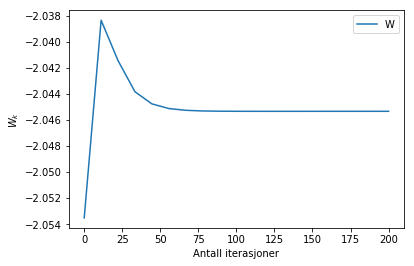

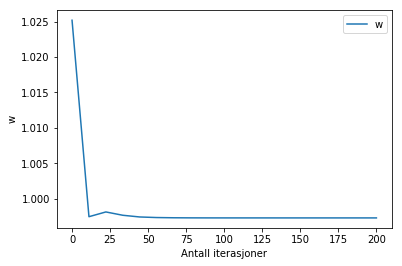

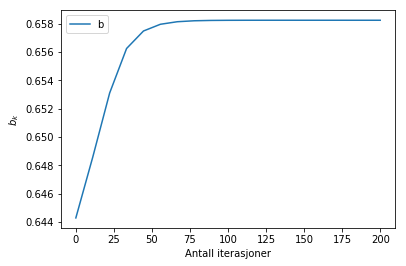

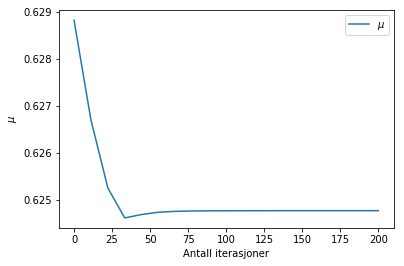

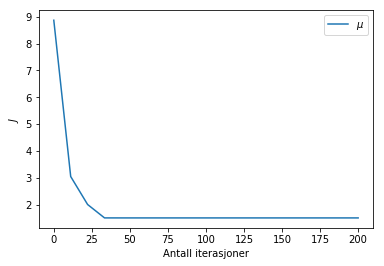

In [283]:
plt.plot(np.linspace(0,200,put), WL[:put], label = 'W')
plt.legend()
plt.xlabel('Antall iterasjoner')
plt.ylabel('$W_{k}$')
plt.show()

plt.plot(np.linspace(0,200,put), wL[:put], label = 'w')
plt.xlabel('Antall iterasjoner')
plt.ylabel('w')
plt.legend()
plt.show()

plt.plot(np.linspace(0,200,put), bL[:put], label = 'b')
plt.xlabel('Antall iterasjoner')
plt.ylabel('$b_{k}$')
plt.legend()
plt.show()

plt.plot(np.linspace(0,200,put), myL[:put], label = '$μ$')
plt.xlabel('Antall iterasjoner')
plt.ylabel('$μ$')
plt.legend()
plt.show()

plt.plot(np.linspace(0,200,put), JL[:put], label = '$μ$')
plt.xlabel('Antall iterasjoner')
plt.ylabel('$J$')
plt.legend()
plt.show()

Tok ut noen verdier i $W$, $b$, $w$ og $μ$ for å se hvordan de varierte mot antall iterasjoner. Ser at de konverterer ganske bra allerede etter $75$ iterasjoner. Sammenlignet med spiraleksempelet konvergerer det mye raskere. Grunnen til at parameterene konvergerer raskere enn ved Spiraleksempelet er trolig fordi det er mye mer informasjon ved et bilde ($784$ piksler) enn ved et punkt ($2$ piksler). 

In [275]:
r = 0
feil = np.zeros(I)
for i in range(I):
            if Z(Y)[i]>0.5 and c[i]==1:
                r+=1
            elif Z(Y)[i]<0.5 and c[i]==0:
                r+=1
            else: 
                feil[i] = 1
printmd("**Ved kjøring av treningsbilder ble resultatet**" + " " + str((r/I)*100)+  "%.")
indeksfeil = []
for i in range(len(feil)): 
    if feil[i] == 1: 
        indeksfeil.append(i)

**Ved kjøring av treningsbilder ble resultatet** 99.7%.

# TEST-BILDER MNIST #

In [276]:
Y0,c0=get_dataset(dataset="training", digit1=2, digit2=7, path=".")
c0 = c0[500:500+I]#henter ut antall bilder
c0 = c0*1
c = c0
Y0 = Y0/(900) #alle blir da et tall mellom 0 og 0.3
Y0 = Y0[:,500:500+I] #henter ut antall bilder
Y[0] = Y0

**Oppdaterer Y med trente matriser og vektorer**

In [277]:
for i in range(K-1):
    Y[i+1,:,:] = yNext(Y, W, b, i)

In [278]:
r = 0
feil = np.zeros(I)
for i in range(I):
    if Z(Y)[i]>0.5 and c[i]==1:
        r+=1
    elif Z(Y)[i]<0.5 and c[i]==0:
        r+=1
    else: 
        feil[i] = 1
    
printmd("**Ved kjøring av testbilder med opptrente matriser og vektorer ble resultatet**" + " " + str((r/I)*100) + "%.")

indeksfeil = []
for i in range(len(feil)): 
    if feil[i] == 1: 
        indeksfeil.append(500+i)

**Ved kjøring av testbilder med opptrente matriser og vektorer ble resultatet** 98.5%.

**Bildene dataprogrammet ikke klarte å gjennkjenne:**

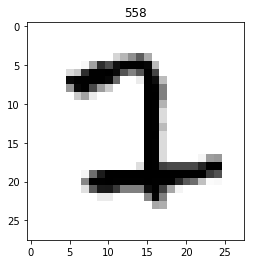

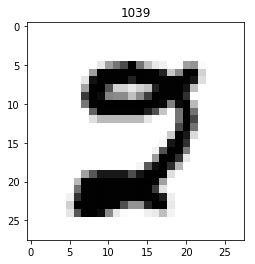

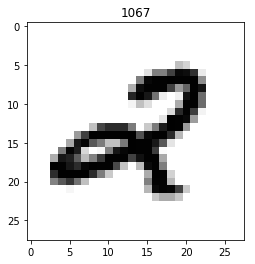

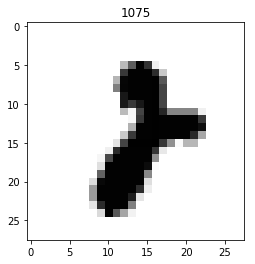

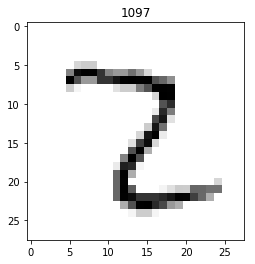

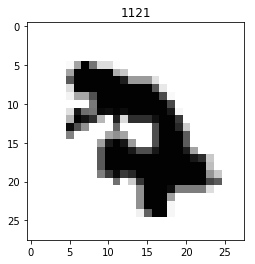

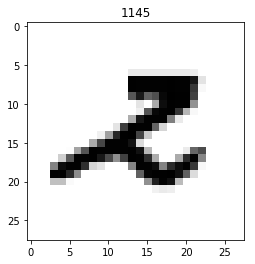

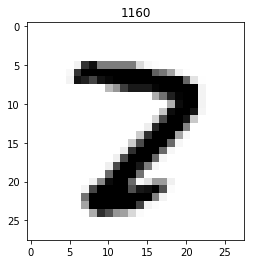

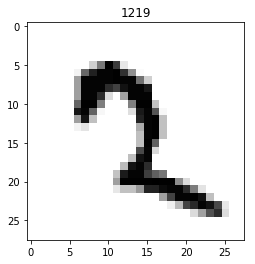

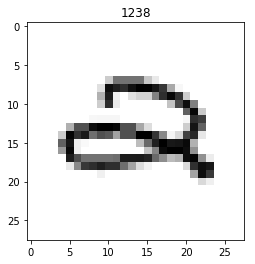

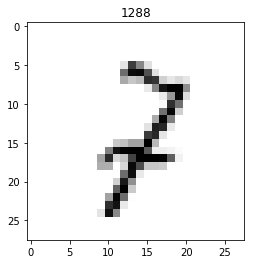

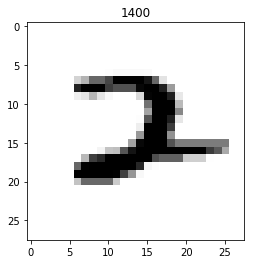

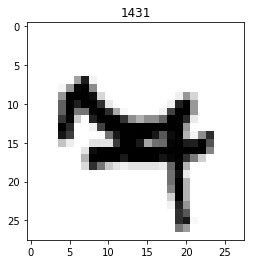

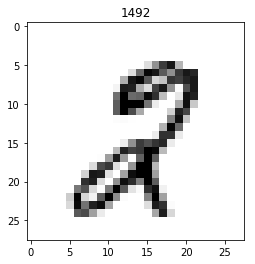

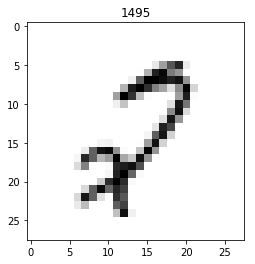

In [279]:
for i in range(len(indeksfeil)):
    printOnePicture(indeksfeil[i])

Ved å se gjennom bildene viser det seg at algoritmen har litt problemer med 7-tall med strek og 2-tall med krøll og tall som ikke samsvarer med de typiske 2- og 7-tall. Om algoritmen skulle fungert optimalt burde vi kjørt alle bildene som lå i MNIST-trenignssettet for å kunne gjennkjenne flere i test-settet. 